# Lab 4

We will be building and training a basic character-level Recurrent Neural
Network (RNN) to classify words. This lab is based on Based on ["NLP From Scratch: Classifying Names with a Character-Level RNN"](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) by [Sean Robertson](https://github.com/spro).

A character-level RNN reads words as a series of characters and for each one it (a) produces an output, and (b) updates a hidden state vector. The output hidden state from one step is in the input to the next step. In this lab, the final prediction will be made based on the last output.

The task we'll consider is predicting the language of origin of a name.
We'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling. For example:

```sh
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```


## Download the Data

Download the data and extract it:

1. Open a terminal (purple + button in the top left, then select Terminal in the bottom row)
2. Run:

```
wget https://download.pytorch.org/tutorial/data.zip
unzip data.zip
```

## Preparing the Data

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.


In [1]:
from io import open
import glob
import os

# Get files
def findFiles(path):
    return glob.glob(path)

print("Files found:")
print(findFiles('data/names/*.txt'))

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("\nExample conversion from Unicode to ASCII:")
print("Input: Ślusàrski")
print("Output:", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Files found:
['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']

Example conversion from Unicode to ASCII:
Input: Ślusàrski
Output: Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [19]:
print(category_lines['Italian'])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abello', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai', 'Acciaio', 'Acciaioli', 'Acconci', 'Acconcio', 'Accorsi', 'Accorso', 'Accosi', 'Accursio', 'Acerbi', 'Acone', 'Aconi', 'Acqua', 'Acquafredda', 'Acquarone', 'Acquati', 'Adalardi', 'Adami', 'Adamo', 'Adamoli', 'Addario', 'Adelardi', 'Adessi', 'Adimari', 'Adriatico', 'Affini', 'Africani', 'Africano', 'Agani', 'Aggi', 'Aggio', 'Agli', 'Agnelli', 'Agnellutti', 'Agnusdei', 'Agosti', 'Agostini', 'Agresta', 'Agrioli', 'Aiello', 'Aiolfi', 'Airaldi', 'Airo', 'Aita', 'Ajello', 'Alagona', 'Alamanni', 'Albanesi', 'Albani', 'Albano', 'Alberghi', 'Alberghini', 'Alberici', 'Alberighi', 'Albero', 'Albini', 'Albricci', 'Albrici', 'Alcheri', 'Aldebrandi', 'Alderisi', 'Alduino', 'Alemagna', 'Alep

### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a one-hot vector of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.
In lecture 1, we noted that usually we use special data structures to avoid memory overhead (e.g., dictionaries or sparse vectors).
In this lab, we'll use a normal vector for convenience.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print("This is the tensor for 'J':")
print(letterToTensor('J'))

print("\nThis is the dimensionality of the matrix for 'Jones':")
print(lineToTensor('Jones').size())

This is the tensor for 'J':
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

This is the dimensionality of the matrix for 'Jones':
torch.Size([5, 1, 57])


## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with
a ``LogSoftmax`` layer after the output.




In [78]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the layers of the model
        # These also create the weights where needed
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # Set the weights to some initial values
        self.init_weights()
        
    def init_weights(self):
        # Initialise the weights to be random values in the matrices and zero for the biases
        initrange = 0.1
        self.i2h.weight.data.uniform_(-initrange, initrange)
        self.i2h.bias.data.zero_()
        self.h2o.weight.data.uniform_(-initrange, initrange)
        self.h2o.bias.data.zero_()
        
    def initHidden(self):
        # Define the initial hidden state
        # Here we use an all zero vector
        return torch.zeros(1, self.hidden_size)

    def forward(self, input_tensor, hidden):
        # Given an input, compute the steps defined by the model

        # Concatenate the input and hidden vectors
        combined = torch.cat((input_tensor, hidden), 1)
        
        # Apply a linear layer to get the new hidden vector
        hidden = self.i2h(combined)

        # Apply a linear layer to get the output scores
        output = self.h2o(hidden)

        # Use softmax to turn the scores into probabilities
        output = self.softmax(output)
        return output, hidden

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).

Note - we haven't trained the model yet, so it's outputs will be random.



In [5]:
input_tensor = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_tensor, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
precomputing batches of Tensors.




In [6]:
print("Running 'Albert' through the RNN")
input_tensor = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_tensor[0], hidden)

print("\nLikelihood for each label is:")
print(output)

Running 'Albert' through the RNN

Likelihood for each label is:
tensor([[-2.9116, -2.8747, -2.9155, -2.9160, -2.8815, -2.9172, -2.9344, -2.8851,
         -2.8338, -2.9117, -2.8801, -2.9301, -2.8586, -2.8916, -2.8886, -2.8625,
         -2.8528, -2.8877]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).

# Task 1

Write code using pytorch operators to convert these to probabilities by exponentiating them (ie, f(x) = exp(x)). Print the result. You should find that they are all around 5% - 6%.

In [10]:
# TODO
import math
probabilities = []
for entry1 in output:
    for entry in entry1:
        probabilities.append(math.exp(entry))
print(str(probabilities))

[0.05438889159769136, 0.05643257859981654, 0.05417808942828872, 0.054150931653534864, 0.05605158567018167, 0.054086197955821855, 0.05316464367000151, 0.05585151422758167, 0.058790161145640646, 0.05438265467331738, 0.05613094222248192, 0.0533902876589362, 0.05735069383087577, 0.05548570081985282, 0.05565527511002109, 0.05712423088286325, 0.05767977030549962, 0.055705747677060234]


## Training
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


We will also want a quick way to get a training example (a name and its
language). We use randomness here as training on the same instances in the same order can lead to worse results as we overfit that particular sequence of samples.




In [43]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomChoiceDict(l):
    i = random.randint(0, len(l) - 1)
    j = 0
    for key in l:
        if i == j:
            return key
        j += 1
        


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

print("Here are 10 examples of randomly choosing data samples:")
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

Here are 10 examples of randomly choosing data samples:
category = Italian / line = Bulgarelli
category = Italian / line = Fortunato
category = Czech / line = Kremlacek
category = Italian / line = Ferrara
category = Arabic / line = Nahas
category = Irish / line = Conn
category = French / line = Bonfils
category = Vietnamese / line = Huynh
category = Vietnamese / line = Vuong
category = Japanese / line = Royama


### Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [13]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and do the calculation, keeping the hidden state for the next letter
-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.

**NOTE:** This can take 5-10 minutes to run.


In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 3.0786 Mojar / English ✗ (Russian)
10000 10% (0m 15s) 1.8636 Costa / Czech ✗ (Spanish)
15000 15% (0m 23s) 0.6346 Nizhinsky / Russian ✓
20000 20% (0m 32s) 1.6420 Fairley / Irish ✗ (English)
25000 25% (0m 39s) 0.9758 Tsang / Vietnamese ✗ (Chinese)
30000 30% (0m 47s) 1.3830 Nunes / Arabic ✗ (Portuguese)
35000 35% (0m 56s) 0.7059 Millar / Scottish ✓
40000 40% (1m 3s) 1.1150 Cousineau / French ✓
45000 45% (1m 10s) 0.7782 Varvitsiotes / Greek ✓
50000 50% (1m 17s) 2.0802 Diefenbach / French ✗ (German)
55000 55% (1m 26s) 0.1570 Antoniadis / Greek ✓
60000 60% (1m 35s) 1.1237 Kitchen / English ✓
65000 65% (1m 43s) 2.0811 Hawlata / Spanish ✗ (Czech)
70000 70% (1m 50s) 2.8321 Tonks / Czech ✗ (English)
75000 75% (1m 57s) 0.4759 Sotiris / Greek ✓
80000 80% (2m 5s) 1.3594 Amello / Portuguese ✗ (Italian)
85000 85% (2m 13s) 1.2712 O'Callaghann / German ✗ (Irish)
90000 90% (2m 21s) 1.7732 De la fuente / Dutch ✗ (Spanish)
95000 95% (2m 29s) 7.0223 Comino / Portuguese ✗ (Greek)
100000 100%

### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning.

Note that learning is fast and fairly smooth at first, but then the improvements become smaller and more variable.




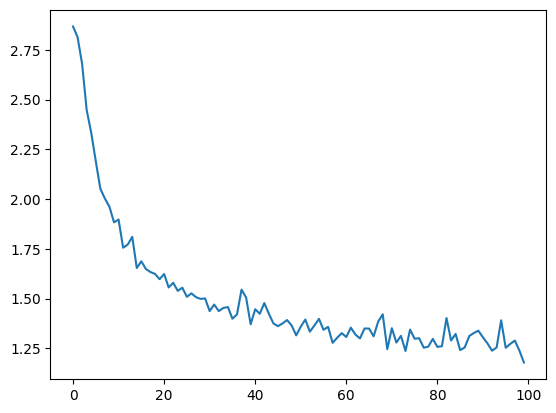

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

Let's see how well the model is doing on the training data. We can get a reasonable estimate with just part of the data, so we'll run 1000 samples through the network with `evaluate()`, which is the same as `train()` minus the backpropagation.




In [17]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

60.5%


The score should be around 50-60%, which may seem low, but consider how tricky this task can be!




### Running on User Input

This function shows the output for a sample input you can provide.

In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Kummerfeld')
predict('Kay')


> Kummerfeld
(-0.75) English
(-0.96) German
(-2.84) Dutch

> Kay
(-1.38) Scottish
(-1.78) Chinese
(-1.98) Vietnamese


# Resources

For more on RNNs, see:

- [Chapter 9 of J+M](https://web.stanford.edu/~jurafsky/slp3/9.pdf)
- [Chapter 7, section 6 of E](https://github.com/jacobeisenstein/gt-nlp-class/blob/master/notes/eisenstein-nlp-notes.pdf)
-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

# Task 2

Above, we trained and tested on the same data. That is misleading, because the model saw those examples during training.

In this task:
1. Modify the data reading process to split the data randomly into a test set (\~10% of the data) and train set (\~90% of the data). Train and test again.
2. Modify `randomTrainingExample` to sample from your training data. Implement a `randomTestExample` to sample from your test data.
3. Create a new instance of the model.
4. Train that instance with the training data you created.
5. Test it with the test data you created.

In [79]:
# TODO
#Part 1
import random
test_set = {}
training_set = {}

for language in category_lines:
    test_set[language] = []
    training_set[language] = []
    for name in category_lines[language]:
        x = random.randint(0, 9)
        if x == 9:
            test_set[language].append(name)
        else:
            training_set[language].append(name)

In [86]:
def randomTrainingExampleTrain():
    category = randomChoiceDict(training_set)
    line = randomChoice(training_set[category])
    i = 0
    for key in training_set:
        if key == category:
            j = i
        i += 1
        
    category_tensor = torch.tensor([j], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

print("Here are 10 examples of randomly choosing data samples:")
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExampleTrain()
    print('category =', category, '/ line =', line)


Here are 10 examples of randomly choosing data samples:
category = Czech / line = Semick
category = Korean / line = Choi
category = Chinese / line = Xuan
category = Arabic / line = Awad
category = Irish / line = Malone
category = Vietnamese / line = Diep
category = Spanish / line = Del bosque
category = Irish / line = O'Byrne
category = Russian / line = Dubrov
category = English / line = Rhoades


In [87]:
#Make new model
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_tensor[0], hidden)

In [88]:
#Train model
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExampleTrain()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 7s) 1.5260 Suh / Chinese ✗ (Korean)
10000 10% (0m 14s) 3.4870 Ganem / Dutch ✗ (Arabic)
15000 15% (0m 21s) 0.1272 Gianakopulos / Greek ✓
20000 20% (0m 28s) 3.1664 Diefenbach / Irish ✗ (German)
25000 25% (0m 35s) 1.7566 Fonda / Spanish ✗ (Italian)
30000 30% (0m 43s) 1.4155 An / Korean ✗ (Vietnamese)
35000 35% (0m 50s) 0.6240 Wawrzaszek / Polish ✓
40000 40% (0m 57s) 0.4407 Peeters / Dutch ✓
45000 45% (1m 4s) 1.2320 Abbatantuono / Spanish ✗ (Italian)
50000 50% (1m 11s) 0.7831 San / Korean ✓
55000 55% (1m 18s) 1.3233 Dufour / French ✓
60000 60% (1m 25s) 0.2951 Handal / Arabic ✓
65000 65% (1m 33s) 0.1164 Cabrera / Spanish ✓
70000 70% (1m 40s) 0.8900 Lefevre / French ✓
75000 75% (1m 47s) 2.0620 Jirik / Korean ✗ (Czech)
80000 80% (1m 55s) 1.0414 Wen / Korean ✗ (Chinese)
85000 85% (2m 2s) 1.0764 Brian / Irish ✓
90000 90% (2m 9s) 1.2110 Escott / English ✓
95000 95% (2m 17s) 0.2634 Jang / Korean ✓
100000 100% (2m 24s) 0.0916 Niemczyk / Polish ✓


In [90]:
def selectTrainingExampleTest(i):
    j = 0
    k = 0
    for key in test_set:
        for val in test_set[key]:
            if j == i:
                line = val
                category = key
                k = j
            j += 1
        k += 1

    category_tensor = torch.tensor(k, dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

total = 1000
correct = 0
# Go through test set
for i in range(total):
    category, line, category_tensor, line_tensor = selectTrainingExampleTest(i)
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

39.7%


# Task 3

The model is entirely linear so far. Modify it to be the basic RNN introduced in lecture 4.

Note - you can do this task without doing Task 2. It is fine to report results on the training set (as the code below does). If you want to combine task 3 and 4 that's okay too (the staff will have both answers).

In the process, also change the weight initialisation to set them to be random values uniformly distributed in the range (-sqrt(k), sqrt(k)) where k is 1/hidden_size.

The cells below contains all the key code from above for easier manipulation.

In [68]:
# Data

from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import numpy

import torch
import torch.nn as nn

# Get files
def findFiles(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [71]:
# Model and Inference

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the structure of the model
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        # Set the weights to some initial values
        self.init_weights()
        
    def init_weights(self):
        # Initialise the weights to be random values in the matrices and zero for the biases
        initrange = math.sqrt(1/self.hidden_size)
        self.i2h.weight.data.uniform_(-initrange, initrange)
        self.i2h.bias.data.zero_()
        self.h2o.weight.data.uniform_(-initrange, initrange)
        self.h2o.bias.data.zero_()
        self.h2h.weight.data.uniform_(-initrange, initrange)
        self.h2h.bias.data.zero_()
        
    def initHidden(self):
        # Define the initial hidden state for an input as all zeros
        return torch.zeros(1, self.hidden_size)

    def forward(self, input_tensor, hidden):
        # Given an input, compute the steps defined by the model
        combined = torch.cat((input_tensor, hidden), 1) #here
        hidden = self.i2h(combined)
        hidden = self.h2h(hidden)
        output = self.h2o(hidden)
        #output becomes tanh
        output = torch.tanh(output)
        
        output = self.softmax(output)
        return output, hidden

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [72]:
# Training

n_iters = 100000
print_every = 5000
plot_every = 1000

criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.8454 Yeon / Irish ✗ (Korean)
10000 10% (0m 21s) 1.9780 Salcedo / Italian ✗ (Spanish)
15000 15% (0m 32s) 2.2122 Bisset / Dutch ✗ (French)
20000 20% (0m 42s) 2.3478 Giang / Vietnamese ✓
25000 25% (0m 53s) 1.8024 Reagan / Arabic ✗ (Irish)
30000 30% (1m 3s) 1.7146 Sun / Vietnamese ✗ (Korean)
35000 35% (1m 14s) 2.1533 Ashley / English ✓
40000 40% (1m 24s) 1.5254 Hajjar / Arabic ✓
45000 45% (1m 34s) 1.6713 Henderson / Scottish ✓
50000 50% (1m 46s) 2.1510 Duarte / French ✗ (Portuguese)
55000 55% (1m 56s) 1.6383 Giang / Vietnamese ✓
60000 60% (2m 6s) 1.7205 Wei / Chinese ✓
65000 65% (2m 17s) 1.7720 Abana / Italian ✗ (Spanish)
70000 70% (2m 27s) 2.0041 Beaumont / Dutch ✗ (French)
75000 75% (2m 38s) 1.9141 Michaud / Arabic ✗ (French)
80000 80% (2m 48s) 1.2204 Vourlis / Greek ✓
85000 85% (2m 59s) 1.4512 Kawamata / Japanese ✓
90000 90% (3m 9s) 1.5023 La / Vietnamese ✓
95000 95% (3m 19s) 1.7392 Nader / German ✗ (Arabic)
100000 100% (3m 29s) 2.0395 Doan / Irish ✗ (Vietnamese)


In [73]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

44.5%
